# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotKmeansPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)

ABC = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC = preprocess_seqs(ABC, "Y")

header = ABC.columns
treatments = ABC.columns[6:]

data = ABC.iloc[:, 6:].T
protnames = ABC.iloc[:, 0]
seqs = ABC.iloc[:, 1]

In [3]:
ABC

,Protein,Sequence,UniprotAcc,Position,r2_Std,BioReps,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,P19174,Y783-p,NA,1,0.891610,-0.132290,0.508638,-0.431225,-0.008149,0.338497,-0.481326,-0.713501,0.547278,-0.519532
3,14-3-3 protein epsilon,GDYHRyLAEFA,P62258,Y131-p,NA,1,0.413272,0.620284,0.352508,-0.291815,0.122734,0.216532,0.167650,-0.586405,-0.395571,-0.619189
4,14-3-3 protein zeta/delta,LLSVAyKNVVG,P63104,Y48-p,NA,1,2.028584,1.620221,1.301309,-0.568873,-0.712916,-0.731959,-0.791261,-0.762381,-0.574292,-0.808433
15,60S ribosomal protein L22-like 1,TYELRyFQISQ,Q6P5R6,Y108-p,NA,1,-0.050440,-0.157775,-0.042431,0.073614,-0.466527,-0.151340,0.006562,-0.384522,1.342117,-0.169258
16,ADP-ribosylation factor-like protein 11,KtTLLyKLKGH,Q969Q4,Y30-p,0.94,2,0.524947,0.122358,0.153717,-0.546423,0.213311,-0.225130,-0.111816,-0.105150,0.030002,-0.055816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,Zinc finger CCCH-type antiviral protein 1,LLSSDyRIING,Q7Z2W4,Y410-p,NA,1,2.169358,1.570918,0.620437,-1.374179,0.289226,-0.012489,0.232086,-0.981527,-1.024902,-1.488927
781,Zinc finger protein 185,GALADyEGKDV,O15231,Y408-p,NA,1,1.316789,0.388504,0.263724,-1.455803,0.597152,0.022433,0.432893,-0.449084,-0.012254,-1.104353
782,Zinc finger protein 185,LFVKEyVNASE,O15231,Y581-p,0.96,2,2.694753,0.852521,0.959014,-1.434426,0.582779,-0.266371,-0.040972,-1.194264,-0.760311,-1.392723
783,Zinc finger protein 185,PVSARySNVSS,O15231,Y597-p,NA,1,0.577963,0.026361,0.046690,0.203022,0.399508,0.017095,-0.176009,-0.181494,-0.215097,-0.698038


### Phenotypes

#### Cell Viability:

In [4]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

# Chained MS mixed clustering + PLSR analysis

In [5]:
ncl = 2
pYTS = "Y"
GMMweight = 2.5
covariance_type = "diag" 
max_n_iter = 20
info = ABC.iloc[:, :6]

In [6]:
MSC = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="PAM250").fit(data, Y_cv)
centers = MSC.transform(data)

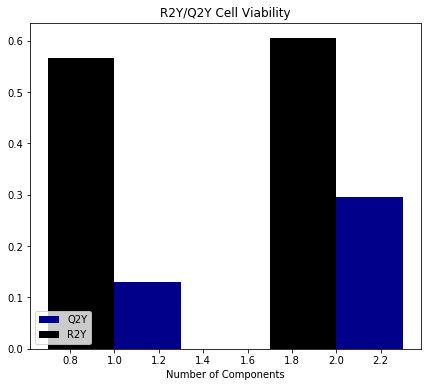

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

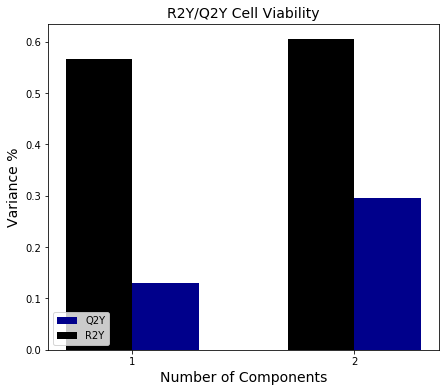

In [8]:
Q2Y = Q2Y_across_components(centers, Y_cv, ncl+1)
R2Y = R2Y_across_components(centers, Y_cv, ncl+1)

range_ = np.linspace(1, ncl, ncl)

fig, axs = plt.subplots(1,1, figsize=(7,6))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability", fontsize=14)
plt.ylabel("Variance %", fontsize=14)
plt.xlabel("Number of Components", fontsize=14)
plt.legend(loc=3);

In [9]:
# CVresults_max, CVresults_min, best_params = MSclusPLSR_tuning(data, seqs, protnames, Y_cv)
# CVresults_min.nlargest(30, "mean_test_scores")

In [10]:
# ncl_GMMweight_ncomp = CVresults_min.sort_values(by="Ranking")
# create_download_link(ncl_GMMweight_ncomp, "ncl_GMMweight_ncomp=2.csv")

Hyperparameter Tuning with Binomial Clustering:

In [11]:
# pd.read_csv('./msresist/data/09252019-HyperparameterTuning_Binomial_ncl_GMMweight_ncomp.csv').iloc[:30, :11].iloc[:, 1:]

Hyperparameter Tuning with PAM250 clustering (n_comp=2):

In [12]:
# pd.read_csv('./msresist/data/10212019-HyperparameterTuning_PAM240_ncl_GMMweight_ncomp=2.csv').iloc[:30, :11].iloc[:, 1:]

In [13]:
ncl, GMMweight, ncomp = 2, 2.5, 2

In [14]:
mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="PAM250")), ('plsr', PLSRegression(ncomp))])

In [15]:
X_scores, Y_scores = mixedCl_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = mixedCl_plsr.named_steps.plsr.x_loadings_[:, 0], mixedCl_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = mixedCl_plsr.named_steps.plsr.y_loadings_[:, 0], mixedCl_plsr.named_steps.plsr.y_loadings_[:, 1]

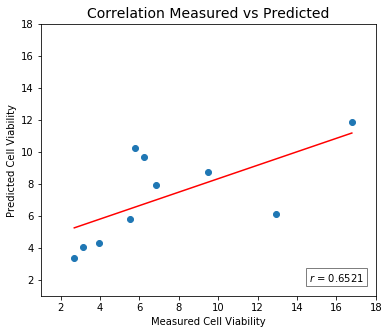

In [16]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)
plt.title("Correlation Measured vs Predicted", fontsize=14);

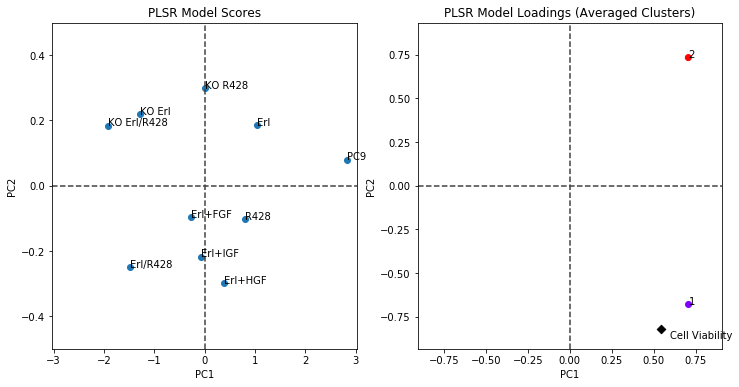

In [17]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
spacer = 0.2
axs[0].set_xlim([(-1*max(PC1_scores))-spacer, max(PC1_scores)+spacer])
axs[0].set_ylim([(-1*max(PC2_scores))-spacer, max(PC2_scores)+spacer])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].annotate("Cell Viability", (PC1_yload+0.05, PC2_yload-0.05))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([(-1*max(list(PC1_xload)+list(PC1_yload)))-spacer, max(list(PC1_xload)+list(PC1_yload))+spacer])
axs[1].set_ylim([(-1*max(list(PC2_xload)+list(PC2_yload)))-spacer, max(list(PC2_xload)+list(PC2_yload))+spacer]);

In [18]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
clustermembers

,Cluster_1,seqs_Cluster_1,UniprotAcc_Cluster_1,pos_Cluster_1,r2/Std_Cluster_1,BioReps_Cluster_1,Cluster_2,seqs_Cluster_2,UniprotAcc_Cluster_2,pos_Cluster_2,r2/Std_Cluster_2,BioReps_Cluster_2
0,14-3-3 protein zeta/delta,LLSVAyKNVVG,P63104,Y48-p,NA,1,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,P19174,Y783-p,NA,1
1,Actin filament-associated protein 1-like 2,DEEYIyMNKVT,Q8N4X5,Y56-p,NA,1,14-3-3 protein epsilon,GDYHRyLAEFA,P62258,Y131-p,NA,1
2,Actin-related protein 3,EPEDHyFLLTE,P61158,Y109-p,NA,1,60S ribosomal protein L22-like 1,TYELRyFQISQ,Q6P5R6,Y108-p,NA,1
3,Adapter molecule crk,QEEAEyVRALF,P46108,Y136-p,0.85,2,ADP-ribosylation factor-like protein 11,KtTLLyKLKGH,Q969Q4,Y30-p,0.94,2
4,Afadin,TYTREyFTFPA,P55196,Y1230-p,0.63,2,ADP/ATP translocase 2,ANVIRyFPTQA,P05141,Y81-p,NA,1
...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,NaN,NaN,NaN,NaN,NaN,Tyrosine-protein phosphatase non-receptor type 11,QNTGDyYDLYG,Q06124,Y62-p,0.4,3
262,NaN,NaN,NaN,NaN,NaN,NaN,Vasodilator-stimulated phosphoprotein,SRVQIyHNPTA,P50552,Y39-p,0.72,2
263,NaN,NaN,NaN,NaN,NaN,NaN,Zinc finger protein 185,GALADyEGKDV,O15231,Y408-p,NA,1
264,NaN,NaN,NaN,NaN,NaN,NaN,Zinc finger protein 185,PVSARySNVSS,O15231,Y597-p,NA,1


In [19]:
create_download_link(clustermembers, "DataClustering")

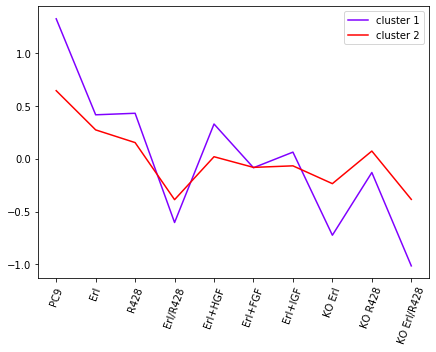

In [20]:
fig = plt.figure(figsize=(7,5))

centers = mixedCl_plsr.named_steps.mixedCl.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.legend()
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);